# Code to train the LogNormMix-Net TPP model

In [1]:
%load_ext autoreload
%autoreload 2
import dpp
import numpy as np
import torch
from copy import deepcopy
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
torch.set_default_tensor_type(torch.cuda.FloatTensor)
import matplotlib.pyplot as plt
import cProfile
import pandas as pd
import math

In [2]:
dpp.data.list_datasets()

['enron_email_dataset', 'eu_email_dataset']

In [3]:
# Config
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
dataset_name = 'enron_email_dataset'  # run dpp.data.list_datasets() to see the list of available datasets

# Model config
## Marks
use_src_marks = True              # Use source marks
src_mark_embedding_size = 24          # Size of the src mark embedding (used as RNN input)
use_dst_marks = True                  # Use destination marks
dst_mark_embedding_size = 24          # Size of the dst mark embedding (used as RNN input)
shared_mark_embedding = False          # Should the source and destination marks share an embedding layer (note, embedding sizes must be the same, and have the same range)

context_size = 64                # Size of the RNN hidden vector
num_mix_components = 30           # Number of components for a mixture model
rnn_type = "LSTM"                  # What RNN to use as an encoder {"RNN", "GRU", "LSTM"}
meta_embedding_size = 16
num_meta_classes = 3
meta_type = 'basic'

# Training config
batch_size = 50       # Number of sequences in a batch
regularization = 1e-3  # L2 regularization parameter
learning_rate = 1e-4   # Learning rate for Adam optimizer
max_epochs = 4000    # For how many epochs to train
display_step = 1       # Display training statistics after every display_step
patience = 200          # After how many consecutive epochs without improvement of val loss to stop training

In [4]:
# Load the data
dataset = dpp.data.load_dataset(dataset_name)
d_train, d_val, d_test = dataset.train_val_test_split(seed=seed)

dl_train = d_train.get_dataloader(batch_size=batch_size, shuffle=True)
dl_val = d_val.get_dataloader(batch_size=batch_size, shuffle=False)
dl_test = d_test.get_dataloader(batch_size=batch_size, shuffle=False)

train_end: 86
val_end: 115


In [5]:
# Define the model
print('Building model...')
mean_log_inter_time, std_log_inter_time = d_train.get_inter_time_statistics()

model = dpp.models.LogNormMixNet(
    use_src_marks=use_src_marks,
    use_dst_marks=use_dst_marks,
    num_src_marks=d_train.num_src_marks,
    num_dst_marks=d_train.num_dst_marks,
    num_meta_classes=num_meta_classes,
    meta_type=meta_type,
    mean_log_inter_time=mean_log_inter_time,
    std_log_inter_time=std_log_inter_time,
    context_size=context_size,
    src_mark_embedding_size=src_mark_embedding_size,
    dst_mark_embedding_size=dst_mark_embedding_size,
    shared_mark_embedding = shared_mark_embedding,
    rnn_type=rnn_type,
    num_mix_components=num_mix_components,
    meta_embedding_size=meta_embedding_size
)
opt = torch.optim.Adam(model.parameters(), weight_decay=regularization, lr=learning_rate)

Building model...


In [6]:
model

LogNormMixNet(
  (src_mark_embedding): Embedding(54, 24)
  (src_mark_linear1): Linear(in_features=64, out_features=150, bias=True)
  (src_mark_linear2): Linear(in_features=150, out_features=54, bias=True)
  (dst_mark_embedding): Embedding(164, 24)
  (dst_mark_linear): Linear(in_features=88, out_features=164, bias=True)
  (meta_embedding): Embedding(3, 16)
  (rnn): LSTM(49, 64, batch_first=True)
  (linear): Linear(in_features=80, out_features=90, bias=True)
)

In [7]:
print(f"num params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

num params: 74574


In [8]:
def aggregate_loss_over_dataloader(dl):
    total_loss = 0.0
    total_sender_accuracy = 0
    total_sender_top3 = 0
    total_recip_accuracy = 0
    total_recip_top3 = 0
    total_mark_accuracy = 0
    total_time_log_p = 0.0
    total_src_log_p = 0.0
    total_dst_log_p = 0.0
    total_count = 0
    num_events = 0
    mae_tot = 0.0
    rmse_tot = 0.0
    with torch.no_grad():
        for batch in dl:
            loss, time_log_p, src_log_p, dst_log_p, sender_accuracy, topk_sender, recip_accuracy, topk_recip = model.log_prob(batch)
            seq_lens = batch.pt_size
            num_events += seq_lens
            loss = -loss.sum().item()
            time_log_p = -time_log_p.sum().item()
            src_log_p = -src_log_p.sum().item()
            dst_log_p = -dst_log_p.sum().item()
            sender_accuracy = sender_accuracy.sum().item()
            topk_sender = topk_sender.sum().item()
            recip_accuracy = recip_accuracy.sum().item()
            topk_recip = topk_recip.sum().item()
            total_sender_accuracy += sender_accuracy
            total_sender_top3 += topk_sender
            total_recip_accuracy += recip_accuracy
            total_recip_top3 += topk_recip
            total_loss += loss
            total_time_log_p += time_log_p
            total_src_log_p += src_log_p
            total_dst_log_p += dst_log_p
            total_count += batch.size
            mae, rmse = model.mae(batch)
            mae_tot += mae.sum().item()
            rmse_tot  += rmse.sum().item()
    return total_loss / total_count, total_time_log_p / total_count, total_src_log_p / total_count, total_dst_log_p / total_count, mae_tot/num_events, np.sqrt(rmse_tot/num_events), total_sender_accuracy/num_events, total_sender_top3/num_events, total_recip_accuracy/num_events, total_recip_top3/num_events

In [9]:
# Traning
print('Starting training...')

impatient = 0
best_loss = np.inf
best_model = deepcopy(model.state_dict())
training_val_losses = []
val_mae = []
val_rmse = []
training_trn_losses = []

for epoch in range(max_epochs):
    model.train()
    train_loss = []
    for batch in dl_train:
        opt.zero_grad()
        loss, time_log_p, src_log_p, dst_log_p, train_sender_accuracy, train_sender_top3, train_recip_accuracy, train_recip_top3 = model.log_prob(batch)
        time_log_p = -time_log_p.mean()
        loss = -loss.mean()
        train_loss.append(loss.detach())
        loss.backward()
        opt.step()
        if epoch >= 67:
            model.linear.weight.requires_grad = False
            model.linear.bias.requires_grad = False
            model.context_init.requires_grad = False
            model.meta_embedding.weight.requires_grad = False
            #model.meta_embedding.bias.requires_grad = False
            model.rnn.requires_grad = False
            for param in model.rnn.parameters():
                param.requires_grad = False    
            model.rnn.weight_ih_l0.requireds_grad = False
            model.rnn.weight_hh_l0.requireds_grad = False
            model.rnn.bias_ih_l0.requireds_grad = False
            model.rnn.bias_hh_l0.requireds_grad = False

    model.eval()
    training_trn_losses.append(sum(train_loss)/len(train_loss))
    with torch.no_grad():
        loss_val, time_log_p, src_log_p, dst_log_p, mae, rmse, sender_accuracy_val, sender_top3_val, recip_accuracy_val, recip_top3_val = aggregate_loss_over_dataloader(dl_val)
        training_val_losses.append(loss_val)
        val_mae.append(mae)
        val_rmse.append(rmse)

    if (best_loss - loss_val) < 1e-4:
        impatient += 1
        if loss_val < best_loss:
            print("<e change, new best:", epoch)
            best_loss = loss_val
            best_model = deepcopy(model.state_dict())
    else:
        #print(epoch)
        best_loss = loss_val
        best_model = deepcopy(model.state_dict())
        impatient = 0

    if impatient >= patience:
        print(f'Breaking due to early stopping at epoch {epoch}')
        break

    if epoch % display_step == 0:
        print(f"Epoch {epoch:4d}: loss_train_last_batch = {loss.item():.4f}, loss_val = {loss_val:.4f}, time_log_p={time_log_p:.4f}, time_mae_val={mae:.4f}, time_rmse_val={rmse:.4f}.")
        print(f" src_log_p={src_log_p:.4f}, dst_log_p={dst_log_p:.4f}, sender_accuracy={sender_accuracy_val:.4f}, sender_top3={sender_top3_val:.4f}, recip_accuracy={recip_accuracy_val:.4f}, recip_top3={recip_top3_val:.4f}")

Starting training...
Epoch    0: loss_train_last_batch = 902.5683, loss_val = 771.4056, time_log_p=81.2119, time_mae_val=13.0454, time_rmse_val=9.6568.
 src_log_p=300.6844, dst_log_p=389.5093, sender_accuracy=0.0298, sender_top3=0.0697, recip_accuracy=0.0069, recip_top3=0.0092
Epoch    1: loss_train_last_batch = 923.2604, loss_val = 770.9211, time_log_p=81.1681, time_mae_val=12.7827, time_rmse_val=9.5469.
 src_log_p=300.4986, dst_log_p=389.2543, sender_accuracy=0.0344, sender_top3=0.0752, recip_accuracy=0.0073, recip_top3=0.0092


/datasets/work/d61-decaas/work/moo331/miniconda3/envs/IFLenv/lib/python3.8/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch    2: loss_train_last_batch = 1053.2415, loss_val = 770.4429, time_log_p=81.1258, time_mae_val=12.5310, time_rmse_val=9.4433.
 src_log_p=300.3155, dst_log_p=389.0015, sender_accuracy=0.0376, sender_top3=0.0802, recip_accuracy=0.0073, recip_top3=0.0092
Epoch    3: loss_train_last_batch = 1043.9204, loss_val = 769.9678, time_log_p=81.0857, time_mae_val=12.2837, time_rmse_val=9.3434.
 src_log_p=300.1334, dst_log_p=388.7488, sender_accuracy=0.0417, sender_top3=0.0871, recip_accuracy=0.0073, recip_top3=0.0101
Epoch    4: loss_train_last_batch = 840.5334, loss_val = 769.4957, time_log_p=81.0468, time_mae_val=12.0425, time_rmse_val=9.2479.
 src_log_p=299.9525, dst_log_p=388.4964, sender_accuracy=0.0454, sender_top3=0.0907, recip_accuracy=0.0073, recip_top3=0.0115
Epoch    5: loss_train_last_batch = 1108.9692, loss_val = 769.0249, time_log_p=81.0079, time_mae_val=11.8150, time_rmse_val=9.1592.
 src_log_p=299.7720, dst_log_p=388.2450, sender_accuracy=0.0490, sender_top3=0.0949, recip_accu

In [10]:
# Evaluation
model.load_state_dict(best_model)
model.eval()

# All training & testing sequences stacked into a single batch
with torch.no_grad():
    final_loss_train, train_time_log_p, train_src_log_p, train_dst_log_p, train_time_mae, train_time_rmse, train_sender_accuracy, train_sender_top3, train_recip_accuracy, train_recip_top3 = aggregate_loss_over_dataloader(dl_train)
    final_loss_val, val_time_log_p, val_src_log_p, val_dst_log_p, val_time_mae, val_time_rmse, val_sender_accuracy, val_sender_top3, val_recip_accuracy, val_recip_top3 = aggregate_loss_over_dataloader(dl_val)
    final_loss_test, test_time_log_p, test_src_log_p, test_dst_log_p, test_time_mae, test_time_rmse, test_sender_accuracy, test_sender_top3, test_recip_accuracy, test_recip_top3 = aggregate_loss_over_dataloader(dl_test)

In [11]:
print(f'Negative log-likelihood:\n'
      f' - Train: {final_loss_train:.4f}. Time-log-p: {train_time_log_p}. Src-log-p: {train_src_log_p}. Dst-log-p:{train_dst_log_p}. MAE: {train_time_mae}. RMSE: {train_time_rmse}, sender accuracy: {train_sender_accuracy}, sender top3: {train_sender_top3}, recip accuracy: {train_recip_accuracy}, recip top3: {train_recip_top3} \n'
      f' - Val:   {final_loss_val:.4f}. Time-log-p: {val_time_log_p}. Src-log-p: {val_src_log_p}. Dst-log-p:{val_dst_log_p}.MAE: {val_time_mae}. RMSE: {val_time_rmse}, sender accuracy: {val_sender_accuracy}, sender top3: {val_sender_top3}, recip accuracy: {val_recip_accuracy}, recip_top3: {val_recip_top3}\n'
      f' - Test:  {final_loss_test:.4f}. Time-log-p: {test_time_log_p}. Src-log-p: {test_src_log_p}. Dst-log-p:{test_dst_log_p}.. MAE: {test_time_mae}. RMSE: {test_time_rmse}. Sender: {test_sender_accuracy}. sender top3: {test_sender_top3}. Recip: {test_recip_accuracy}. recip_top3: {test_recip_top3}'
     )

Negative log-likelihood:
 - Train: 572.8481. Time-log-p: 83.32096259538517. Src-log-p: 289.8747956031977. Dst-log-p:199.65234375. MAE: 5.4707026601362605. RMSE: 6.25026463202701, sender accuracy: 0.2430084493633226, sender top3: 0.4479352612162323, recip accuracy: 0.3817684160418898, recip top3: 0.6685707485421873 
 - Val:   494.6958. Time-log-p: 79.80419921875. Src-log-p: 241.62084119073276. Dst-log-p:173.27070985991378.MAE: 7.261393825905133. RMSE: 7.756081574245001, sender accuracy: 0.2158570119156737, sender top3: 0.41200733272227313, recip accuracy: 0.34922089825847846, recip_top3: 0.6232813932172319
 - Test:  663.7625. Time-log-p: 79.09561893857759. Src-log-p: 341.5200026939655. Dst-log-p:243.14683795797413.. MAE: 5.349578093718718. RMSE: 6.129481372519434. Sender: 0.19352686019352686. sender top3: 0.3680347013680347. Recip: 0.33633633633633636. recip_top3: 0.6106106106106106


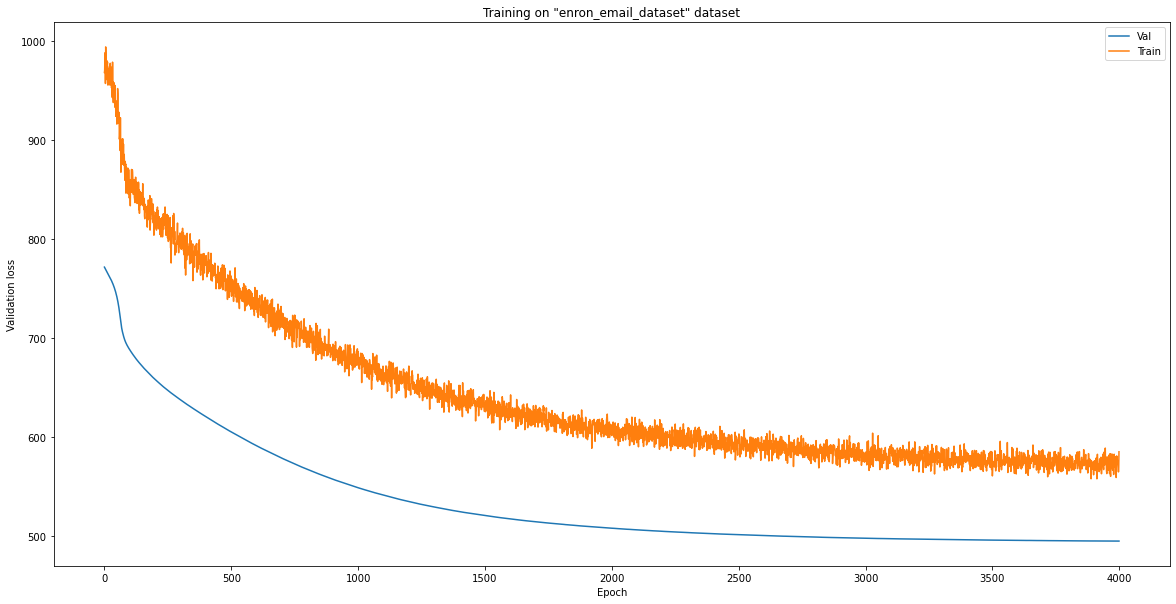

In [12]:
line_val, = plt.plot(range(len(training_val_losses)), training_val_losses)
line_trn, = plt.plot(range(len(training_trn_losses)), training_trn_losses)
handles = [line_val, line_trn]
labels = ["Val", "Train"]
plt.ylabel('Validation loss')
plt.xlabel('Epoch')
plt.title(f'Training on "{dataset_name}" dataset')
plt.legend(handles, labels)
plt.savefig('output/curves.svg', format='svg')
plt.show()

In [13]:
torch.save(model.state_dict(), './models/enron-event-predict-model')


In [ ]:
# Generate events from the trained model

In [14]:
## Load saved model if necessary
model.load_state_dict(torch.load('./models/enron-event-predict-model'))

<All keys matched successfully>

In [ ]:
# Generate 86 weeks worth of events.
# data is in hours. 86 weeks is 14448 hours
sampled_batch, t_end = model.sample(0, t_end=14448, batch_size=1)